In [2]:
from datetime import datetime
import itertools
import json

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)


RUN_FOLDER = "../results/3mo_cross_val/"
NETWORK_FOLDER = "kcm/"
GTFS_FOLDER = "../data/kcm_gtfs/2022_09_19/"
data_folder = RUN_FOLDER + NETWORK_FOLDER + "deeptte_formatted/"

In [22]:
# Read training/testing samples from file
train_data, test_data = data_utils.load_train_test_data(data_folder)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

# Read config from file
with open(data_folder + "config.json", "r") as f:
    config = json.load(f)

# Read GTFS data from file
print(f"Loading and merging GTFS files from '{GTFS_FOLDER}'...")
gtfs_data = data_utils.merge_gtfs_files(GTFS_FOLDER)

Successfully loaded 69845 training samples and 46048 testing samples.
Loading and merging GTFS files from '../data/kcm_gtfs/2022_09_19/'...


In [23]:
device = torch.device("cpu")
EPOCHS = 200
BATCH_SIZE = 16
LEARN_RATE = 1e-3
HIDDEN_SIZE = 32

# Construct dataloaders for Pytorch models
train_dataset = data_loader.make_dataset(train_data, config, device)
test_dataset = data_loader.make_dataset(test_data, config, device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)

# Variables must be changed here, and in data_loader.
# Must change model file if using only continuous or only embedded variables
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24,
        'col': 8
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 9
    },
    'driverID': {
        'vocab_size': 1147, #646 nwy
        'embed_dims': 12,
        'col':10
    }
}
ff_model = basic_ff.BasicFeedForward(
    train_dataloader.dataset[0][0].shape[0],
    embed_dict,
    HIDDEN_SIZE
).to(device)
training_loss, validation_loss = ff_model.fit_to_data(train_dataloader, test_dataloader, LEARN_RATE, EPOCHS)
labels, preds = ff_model.predict(test_dataloader, config)

EPOCH: 0
LOSS: train 0.37735218400168913 valid 0.257811039686203
EPOCH: 1
LOSS: train 0.2537531749111998 valid 0.23903682827949524
EPOCH: 2
LOSS: train 0.2413686713958061 valid 0.23420663177967072
EPOCH: 3
LOSS: train 0.23568393568714388 valid 0.2347009778022766
EPOCH: 4
LOSS: train 0.23048439588264635 valid 0.22686181962490082
EPOCH: 5
LOSS: train 0.2277348624445085 valid 0.22618214786052704
EPOCH: 6
LOSS: train 0.2251576236378789 valid 0.22206903994083405
EPOCH: 7
LOSS: train 0.2211085161364002 valid 0.22126154601573944
EPOCH: 8
LOSS: train 0.2199407447661916 valid 0.21843816339969635
EPOCH: 9
LOSS: train 0.21824896843115016 valid 0.22056901454925537
EPOCH: 10
LOSS: train 0.21706773840365365 valid 0.21749287843704224
EPOCH: 11
LOSS: train 0.2162935017312455 valid 0.21788619458675385
EPOCH: 12
LOSS: train 0.2148936939439845 valid 0.21187962591648102
EPOCH: 13
LOSS: train 0.2132863558059199 valid 0.21938514709472656
EPOCH: 14
LOSS: train 0.2118333067170733 valid 0.21549691259860992
EPO

<AxesSubplot: xlabel='Epoch', ylabel='value'>

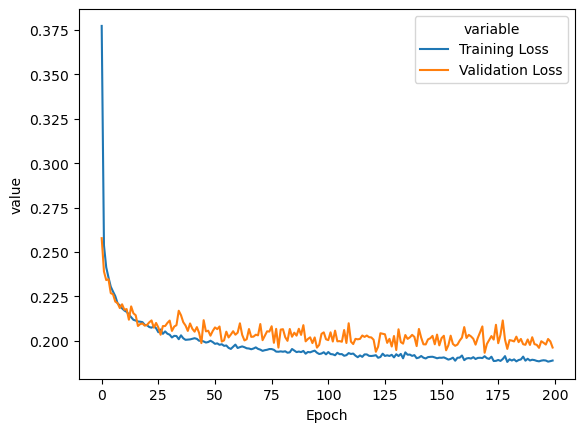

In [24]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [25]:
# Look at predictions
print(f"MAPE: {metrics.mean_absolute_percentage_error(labels, preds)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(labels, preds))}")
print(f"MAE: {metrics.mean_absolute_error(labels, preds)}")

MAPE: 0.1280716359615326
RMSE: 519.3350219726562
MAE: 357.921875
